In [1]:
#Import thư viện để để tính toán model
from docplex.mp.model import Model

#Import thư viện numpy và pandas
import pandas as pd
import numpy as np

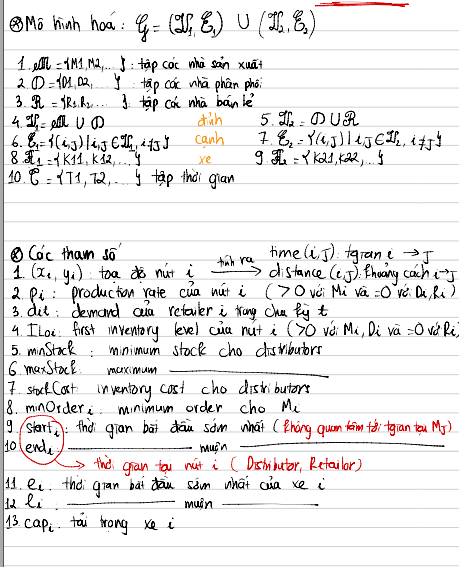

In [2]:
#Import những tham số đầu vào của các node

#Import những biến đầu vào về tồn kho

minimumStock = 0
maximumStock = 300
# maximumStock1 = 300
# maximumStock2 = 300
stockCost = 0.75

#Khai báo số ngày tiến hành chạy mô hình
Time = list(range(1, 4))

#Insert dữ liệu của nhà sản xuất (NodeID, X, Y, ProductionRate, FirstInventory, NodeType, MinimumOrder)
Suppliers = pd.read_excel("Input data.xlsx", sheet_name='Supplier').set_index('NodeID').to_dict(orient = 'index')

#Insert dữ liệu của Distributor ((NodeID, X, Y, FirstInventory, NodeType, StartTime, EndTime)
Distributor = pd.read_excel("Input data.xlsx", sheet_name='Distributor').set_index('NodeID').to_dict(orient = 'index')

#Insert dữ liệu của Retailer (NodeID, X, Y, NodeType, StartTime, EndTime, Demand)
Retailer = pd.read_excel("Input data.xlsx", sheet_name='Retailer').set_index('NodeID').to_dict(orient = 'index')   

#Đổi lại kiểu dữ liệu của Demand về thành list
for r, d in Retailer.items():
     d['Demand'] = d['Demand'].split(',')

#Thêm một dictionary tự gen ra distributor return
returnDistributor = pd.read_excel("Input data.xlsx", sheet_name='returnDistributor').set_index('NodeID').to_dict(orient = 'index')

In [3]:
#Import dữ liệu những tham số đầu khác

#Tính chất xe trong echelon1 (xe ở echelon 1 không có starttime và endtime)
VehicleE1 = pd.read_excel("Input data.xlsx", sheet_name='VehicleE1').set_index('VehicleID').to_dict(orient = 'index')

#Tính chất xe trong echelon2 (xe ở echelon 1 không có starttime và endtime)
VehicleE2 = pd.read_excel("Input data.xlsx", sheet_name='VehicleE2').set_index('VehicleID').to_dict(orient = 'index')


In [4]:
#Tập hợp tất cả các điểm của echelon 1
N1 = {**Suppliers, **Distributor}

#Tập hợp tất cả các điểm của echelon 2
N2 = {**Retailer,**Distributor, **returnDistributor}

<h1> Check đoạn tạo cung đường này lại một lần nữa nhé Chí xem nó gen đúng chưa ---> đúng rồi anh nhé!<h1>

In [5]:
#Cung đường của echelon 1, các nhà cung cấp sẽ không đi qua lại lẫn nhau, các distributor không qua lại lẫn nhau
E1 = [] 

for i in N1.keys():
    for j in N1.keys():
                if i != j and N1[i]['NodeType'] != N1[j]['NodeType']:
                    E1.append((i, j))


#Cung đường của echelon 2, các retailer có thể qua lại lẫn nhau, các distributor không qua lại lẫn nhau
E2 = [] 

for k1, v1 in N2.items():
    for k2, v2 in N2.items():
                if k1 != k2 and \
                    (v1['NodeType'] != 'Distributor' or v2['NodeType'] != 'Distributor') and \
                    (k1 not in returnDistributor.keys()) and \
                    (v1['NodeType'] != 'Distributor' or v2['NodeType'] != 'returnDistributor') and \
                    (v1['NodeType'] != 'Retailer' or v2['NodeType'] != 'Distributor'):
                        E2.append((k1, k2))

E2

[('R1', 'R2'),
 ('R1', 'R3'),
 ('R1', 'R4'),
 ('R1', 'R5'),
 ('R1', 'R6'),
 ('R1', 'R7'),
 ('R1', 'R8'),
 ('R1', 'R9'),
 ('R1', 'R10'),
 ('R1', 'R11'),
 ('R1', 'R12'),
 ('R1', 'R13'),
 ('R1', 'R14'),
 ('R1', 'R15'),
 ('R1', 'R16'),
 ('R1', 'R17'),
 ('R1', 'R18'),
 ('R1', 'R19'),
 ('R1', 'R20'),
 ('R1', 'returnD1'),
 ('R1', 'returnD2'),
 ('R2', 'R1'),
 ('R2', 'R3'),
 ('R2', 'R4'),
 ('R2', 'R5'),
 ('R2', 'R6'),
 ('R2', 'R7'),
 ('R2', 'R8'),
 ('R2', 'R9'),
 ('R2', 'R10'),
 ('R2', 'R11'),
 ('R2', 'R12'),
 ('R2', 'R13'),
 ('R2', 'R14'),
 ('R2', 'R15'),
 ('R2', 'R16'),
 ('R2', 'R17'),
 ('R2', 'R18'),
 ('R2', 'R19'),
 ('R2', 'R20'),
 ('R2', 'returnD1'),
 ('R2', 'returnD2'),
 ('R3', 'R1'),
 ('R3', 'R2'),
 ('R3', 'R4'),
 ('R3', 'R5'),
 ('R3', 'R6'),
 ('R3', 'R7'),
 ('R3', 'R8'),
 ('R3', 'R9'),
 ('R3', 'R10'),
 ('R3', 'R11'),
 ('R3', 'R12'),
 ('R3', 'R13'),
 ('R3', 'R14'),
 ('R3', 'R15'),
 ('R3', 'R16'),
 ('R3', 'R17'),
 ('R3', 'R18'),
 ('R3', 'R19'),
 ('R3', 'R20'),
 ('R3', 'returnD1'),
 ('R3',

In [6]:
#Notes sau này sẽ cần phải API để lấy được quãng đường thực tế ở echelon 2

#Khai báo thông tin về quãng đường của echelon 2
def euclidean_distance(x1, x2, x3, x4):
    return np.sqrt((x1 - x2) ** 2 + (x3 - x4) ** 2)

distance_list = {}

for e1 in E1:
    distance_list[e1] = euclidean_distance(N1[e1[0]]['X'], N1[e1[1]]['X'], N1[e1[0]]['Y'], N1[e1[1]]['Y'])
    
for e2 in E2:
    distance_list[e2] = euclidean_distance(N2[e2[0]]['X'], N2[e2[1]]['X'], N2[e2[0]]['Y'], N2[e2[1]]['Y'])

distance_list[('R1', 'R2')]

2.23606797749979

In [7]:
#Khai báo biến quyết định
mdl = Model()

#KHAI BÁO ECHELON 1
#Biến quyết định giao hàng từ manufacturer m tới distributor d bằng xe v tại thời điểm t trong E1
u = {(e1, VE1, T): mdl.binary_var(name='u_{}_{}_{}'.format(e1, VE1, T))
     for e1 in E1
            for VE1 in VehicleE1.keys()
                for T in Time}


#Biến lượng giao hàng từ manufacturer m tới distributor d bằng xe v tại thời điểm t trong E1
delivery = {(e1, VE1, T): mdl.integer_var(lb=0, name='delivery_{}_{}_{}'.format(e1, VE1, T))
     for e1 in E1
            for VE1 in VehicleE1.keys()
                for T in Time}

#Inventory level của manufacturer m
inventoryLevelM = {(M, T): mdl.integer_var(lb=0, name='inventoryLevelM_{}_{}'.format(M, T))
     for M in Suppliers.keys()
        for T in Time} 


#Inventory level của distributor d
inventoryLevelD = {(D, T): mdl.integer_var(lb=0, name='inventoryLevelD_{}_{}'.format(D, T))
     for D in Distributor.keys()
        for T in Time}

#KHAI BÁO ECHELON 2
#Biến quyết định giao hàng từ distributor d tới retailer r bằng xe v tại thời điểm t trong E2
x = {(e2, VE2, T): mdl.binary_var(name='x_{}_{}_{}'.format(e2, VE2, T))
     for e2 in E2
         for VE2 in VehicleE2.keys()
             for T in Time}

#Biến quyết định thời gian giao hàng từ distributor d tới retailer r bằng xe v tại thời điểm t trong E2
s = {(n2, VE2, T): mdl.continuous_var(name='s_{}_{}_{}'.format(n2, VE2, T))
     for n2 in N2.keys()
         for VE2 in VehicleE2.keys() 
             for T in Time}

#Biến quyết định biến đổi Linear (dùng trong tuyến tính hoá constraint về thời gian trong E2)
m = {(e2, T): mdl.continuous_var(name='m_{}_{}'.format(e2, T))
     for e2 in E2 
        for T in Time}

# print(u[(('M1', 'D1'), 'VE11', 1)])
print(inventoryLevelM)

{('M1', 1): docplex.mp.Var(type=I,name='inventoryLevelM_M1_1'), ('M1', 2): docplex.mp.Var(type=I,name='inventoryLevelM_M1_2'), ('M1', 3): docplex.mp.Var(type=I,name='inventoryLevelM_M1_3'), ('M2', 1): docplex.mp.Var(type=I,name='inventoryLevelM_M2_1'), ('M2', 2): docplex.mp.Var(type=I,name='inventoryLevelM_M2_2'), ('M2', 3): docplex.mp.Var(type=I,name='inventoryLevelM_M2_3'), ('M3', 1): docplex.mp.Var(type=I,name='inventoryLevelM_M3_1'), ('M3', 2): docplex.mp.Var(type=I,name='inventoryLevelM_M3_2'), ('M3', 3): docplex.mp.Var(type=I,name='inventoryLevelM_M3_3')}


In [8]:
#Khai báo các ràng buộc

#Echelon 1
#(1) Ràng buộc các xe xuất phát từ supplier 
for k1 in VehicleE1:
    for t in Time:
        mdl.add_constraint(mdl.sum(u[e1, k1, t] for e1 in E1 if e1[0] in Suppliers) <= 1, ctname= f'visitOnceE1_{k1}_{t}')
        
#(2) Ràng buộc xe đi từ supplier nào thì về supplier tương ứng
for k1 in VehicleE1:
    for t in Time:
        for e1 in E1:
            mdl.add_constraint(u[e1, k1, t] == u[(e1[1],e1[0]), k1, t], ctname= f'mustReturnE1_{e1}_{k1}_{t}')
            
#(3) Lượng vận chuyển nhỏ hơn số lượng hiện có của supplier
for su in Suppliers:
    for t in Time:
        mdl.add_constraint(mdl.sum(delivery[e1, k1, t] for e1 in E1 for k1 in VehicleE1 if e1[0] == su) <= inventoryLevelM[su,t], ctname=f'stockE1_{su}_{t}')

#(4) Ràng buộc về mặt logic
for e1 in E1:
    for k1 in VehicleE1:
        for t in Time:
            mdl.add_constraint(10000000*u[e1,k1,t] >= delivery[e1,k1,t], ctname=f'existDelivery_{e1}_{k1}_{t}')

#(5) Ràng buộc lượng vận chuyển thoả mãn tải trọng xe trong E1
for e1 in E1:
    for k1 in VehicleE1:
        for t in Time:
            mdl.add_constraint(delivery[e1,k1,t] <= VehicleE1[k1]['Capacity'], ctname=f'capLimitE1_{e1}_{k1}_{t}')
            
#(6) Lượng delivery phải lớn hơn lượng minimum được quy định bởi supplier
for e1 in E1:
    for k1 in VehicleE1:
        for t in Time:
            for su in Suppliers:
                if e1[0] == su:
                    mdl.add_constraint(u[e1,k1,t]*Suppliers[su]['MinOrder'] <= delivery[e1,k1,t], ctname=f'minimumOrder_{e1}_{k1}_{t}')
    
#Nối Echelon 1 và Echelon 2
#(7) Khởi tạo inventorylevelM ngày 1 cho supplier m
for su in Suppliers:
    for t in Time:
        if t==1:
            mdl.add_constraint(inventoryLevelM[su,t] == Suppliers[su]['FirstInventory']
    + Suppliers[su]['ProductionRate']
    - mdl.sum(delivery[e1,k1,t] for e1 in E1 for k in VehicleE1 if e1[0] == su), ctname=f'firstInventoryM_{su}_{t}')           

#(8) Update inventoryLevelM các ngày tiếp theo cho supplier m
        if t>1:
            mdl.add_constraint(inventoryLevelM[su,t] == inventoryLevelM[su,t-1]
    + Suppliers[su]['ProductionRate']
    - mdl.sum(delivery[e1,k1,t] for e1 in E1 for k in VehicleE1 if e1[0] == su), ctname=f'updateInventoryM_{su}_{t}')

#(9) Khởi tạo inventoryLevelD ngày 1 cho distributor d
for d in Distributor:
    for t in Time:
        if t==1:
            mdl.add_constraint(inventoryLevelD[d,t] == Distributor[d]['FirstInventory']
    + mdl.sum(delivery[e1,k1,t] for e1 in E1 for k1 in VehicleE1 if e1[1] == d)
    - mdl.sum(x[e2,k2,t]*int(Retailer[r]['Demand'][t-1]) for e2 in E2 for k2 in VehicleE2 for r in Retailer if VehicleE2[k2]['StartAt']==d and e2[1] == r), ctname=f'firstInventoryD_{d}_{t}')           

#(10) Update inventoryLevelD các ngày tiếp theo cho distributor d
        if t>1:
            mdl.add_constraint(inventoryLevelD[d,t] == inventoryLevelD[d,t-1]
    + mdl.sum(delivery[e1,k1,t] for e1 in E1 for k1 in VehicleE1 if e1[1] == d)
    - mdl.sum(x[e2,k2,t]*int(Retailer[r]['Demand'][t-1]) for e2 in E2 for k2 in VehicleE2 for r in Retailer if VehicleE2[k2]['StartAt']==d and e2[1] == r), ctname=f'updateInventoryD_{d}_{t}')           

#(11) Minimum stock cho distributor d
for d in Distributor:
    for t in Time:
        mdl.add_constraint(inventoryLevelD[d,t] >= minimumStock, ctname=f'minStockDistributor_{d}_{t}')  

#(12) Maximum stock cho distributor d (giống nhau)
        mdl.add_constraint(inventoryLevelD[d,t] <= maximumStock, ctname=f'maxStockDistributor_{d}_{t}')  

# Maximum stock cho distributor d (khác nhau)
#         if d=='D1':
#             mdl.add_constraint(inventoryLevelD[d,t] <= maximumStock1, ctname=f'maxStockDistributor1_{d}_{t}') 
#         if d=='D2':
#             mdl.add_constraint(inventoryLevelD[d,t] <= maximumStock2, ctname=f'maxStockDistributor2_{d}_{t}') 


#Echelon 2
#(13) Mỗi retailer được visit 1 lần
for r in Retailer:
    for t in Time:
        mdl.add_constraint(mdl.sum(x[e2,k2,t] for e2 in E2 for k2 in VehicleE2 if e2[0]==r)==1, ctname=f'visitOnceE2_{r}_{t}') 

#(14) Ràng buộc tải trọng xe của E2
for k2 in VehicleE2:
    for t in Time:
        mdl.add_constraint(mdl.sum(int(Retailer[r]['Demand'][t-1])* mdl.sum(x[e2,k2,t] for e2 in E2 if e2[0]==r) for r in Retailer) <= int(VehicleE2[k2]['Capacity']), ctname=f'capLimitE2_{k2}_{t}') 

#(15) Ràng buộc xe không nhất thiết rời đi
for k2 in VehicleE2:
    for t in Time:
        mdl.add_constraint(mdl.sum(x[e2,k2,t] for e2 in E2 if VehicleE2[k2]['StartAt']==e2[0])<=1, ctname=f'mustLeaveDepot_{k2}_{t}') 

#(16) Ràng buộc xe không được xuất phát ở những điểm distributor không được chỉ định
        mdl.add_constraint(mdl.sum(x[e2,k2,t] for e2 in E2 if VehicleE2[k2]['StartAt']!=e2[0])==0, ctname=f'mustNotLeaveDepot_{k2}_{t}') 

#(17) Ràng buộc về tiếp hàng xong thì phải rời đi
for r in Retailer:
    for k2 in VehicleE2:
        for t in Time:
            mdl.add_constraint(mdl.sum(x[e2,k2,t] for e2 in E2 if e2[1]==r) - mdl.sum(x[e2,k2,t] for e2 in E2 if e2[0]==r)==0, ctname=f'mustLeaveCustomer_{r}_{k2}_{t}') 

#(18) Ràng buộc xe phải về distributor 
for k2 in VehicleE2:
    for t in Time:
        mdl.add_constraint(mdl.sum(x[e2,k2,t] for e2 in E2 if e2[1] in returnDistributor)<=1, ctname=f'mustReturnDepot_{k2}_{t}') 

#(19) Ràng buộc xe phải về đúng distributor đã xuất phát
        mdl.add_constraint(mdl.sum(x[e2,k2,t] for e2 in E2 if e2[1] in returnDistributor and e2[1]!= VehicleE2[k2]['EndAt'])==0, ctname=f'mustNotReturnDepot_{k2}_{t}')

#(20) Ràng buộc về thời gian
for e2 in E2:
    for k2 in VehicleE2:
        for t in Time:
            mdl.add_constraint(s[e2[0],k2,t] + distance_list[e2]/30 - m[e2,t]*(1 - x[e2,k2,t]) - s[e2[1],k2,t] <=0, ctname=f'travelTime_{e2}_{k2}_{t}') 
    
#(21) Ràng buộc về limit của m (biến quyết định biến đổi tuyến tính)
for e2 in E2:
    for t in Time:
        mdl.add_constraint(m[e2, t] == mdl.max(N2[e2[0]]['EndTime'] + distance_list[e2]/30 - N2[e2[1]]['EndTime']), ctname=f'mLimit_{e2}_{t}') 

#(22) Hoạt động trong thời gian quy định của distributor/retailer trong Echelon 2
for n2 in N2:
    for k2 in VehicleE2:
        for t in Time:
            mdl.add_constraint(N2[n2]['StartTime'] <= s[n2,k2,t], ctname=f'timeWindowE211_{k2}_{t}') 
            mdl.add_constraint(N2[n2]['EndTime'] >= s[n2,k2,t], ctname=f'timeWindowE212_{k2}_{t}') 
            
#(23) Hoạt động trong thời gian quy định của xe 
            mdl.add_constraint(VehicleE2[k2]['StartTime'] <= s[n2,k2,t], ctname=f'timeWindowE221_{k2}_{t}') 
            mdl.add_constraint(VehicleE2[k2]['EndTime'] >= s[n2,k2,t], ctname=f'timeWindowE222_{k2}_{t}') 

In [9]:
#In thử một contraint
# for c in mdl.iter_constraints():
#     print(c)

In [10]:
#Khai báo hàm mục tiêu
#Chi phí E1
costE1 = mdl.sum(u[e1, k1, t] * distance_list[e1] for e1 in E1 for k1 in VehicleE1 for t in Time)

#Chi phí E2
costE2 = mdl.sum(x[e2, k2, t] * distance_list[e2] for e2 in E2 for k2 in VehicleE2 for t in Time)

#Chi phí inventory 
costInt = mdl.sum(inventoryLevelD[d, t] * stockCost for d in Distributor for t in Time)

# Objective function: minimize costE1 + costE2 + costInt
mdl.minimize(costE1 + costE2 + costInt)

In [14]:
#Set time limit
mdl.parameters.timelimit = 120

#Solve the model
solution = mdl.solve()

#Output the solution
if solution:
    mdl.print_solution()
else:
    print("No solution found")

No solution found
